In [4]:
from datetime import datetime
import os
import torch

# Сохранение весов в folder с временной меткой в формате ДД-ММ-ГГ_чч-мм-сс
def save_model_with_timestamp(model, folder='saved_models'):
    try:
        os.makedirs(folder, exist_ok=True)
        
        timestamp = datetime.now().strftime("%d-%m-%y_%H-%M-%S")
        filename = f"w-{timestamp}.pth"
        filepath = os.path.join(folder, filename)
        
        torch.save(model.state_dict(), filepath)

    except Exception as e:
        print(f"Ошибка при сохранении модели: {e}")

In [5]:
from ignite.metrics import Metric

class F1Score(Metric):
    def __init__(self, num_classes=None, average='macro'):
        self._num_classes = num_classes
        self._average = average
        self._confusion_matrix = None
        super(F1Score, self).__init__()

    def reset(self):
        self._confusion_matrix = torch.zeros(
            (self._num_classes, self._num_classes), 
            dtype=torch.long
        )
        super(F1Score, self).reset()

    def update(self, output):
        y_pred, y_true = output
        y_pred = y_pred.argmax(dim=1)
        
        for t, p in zip(y_true.view(-1), y_pred.view(-1)):
            self._confusion_matrix[t.long(), p.long()] += 1

    def compute(self):
        conf_mat = self._confusion_matrix.float()
        
        tp = torch.diag(conf_mat)
        fp = conf_mat.sum(dim=0) - tp
        fn = conf_mat.sum(dim=1) - tp
        
        precision = tp / (tp + fp + 1e-20)
        recall = tp / (tp + fn + 1e-20)
        
        f1_per_class = 2 * (precision * recall) / (precision + recall + 1e-20)
        
        if self._average == 'macro':
            return f1_per_class.mean().item()
        elif self._average == 'micro':
            total_tp = tp.sum()
            total_fp = fp.sum()
            total_fn = fn.sum()
            return (2 * total_tp / (2 * total_tp + total_fp + total_fn)).item()
        else:
            return f1_per_class

In [ ]:

from torch.utils.data import DataLoader
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Loss, Accuracy
import matplotlib.pyplot as plt
from ignite.handlers.param_scheduler import ReduceLROnPlateau
from IPython.display import clear_output

def train_and_evaluate(
    model, 
    train_dataset, 
    test_dataset, 
    BATCH_SIZE=8, 
    NUM_EPOCHS=10, 
    SUBSET_SIZE=None, 
    LR = 0.01,
    folder='saved_models',
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    # Подготовка датасетов и даталодеров
    subset_indices = torch.randperm(len(train_dataset))[:SUBSET_SIZE]
    train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.CrossEntropyLoss()

    model.to(device)
    # Создание тренера и оценщиков
    trainer = create_supervised_trainer(model, optimizer, criterion, device)

    val_metrics = {
        "Accuracy": Accuracy(),
        "F1score": F1Score(num_classes=20),
        "Loss": Loss(criterion)
    }

    train_metrics = {
        "Accuracy": Accuracy(),
        "F1score": F1Score(num_classes=20),
        "Loss": Loss(criterion)
    }

    valid_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
    train_evaluator = create_supervised_evaluator(model, metrics=train_metrics, device=device)

    best_metrics = {
        'Accuracy': -1,
        'F1score': -1,
        'Loss': -1,
        'epoch': -1
    }

    # История значений метрик
    history = {
        'train': {'Loss': [], 'Accuracy': [], 'F1score': []},
        'valid': {'Loss': [], 'Accuracy': [], 'F1score': []}
    }

    
    # Вычисление метрик после каждой эпохи
    @trainer.on(Events.EPOCH_COMPLETED)
    def compute_metrics(engine):
        epoch = engine.state.epoch
        
        # Тренировочные метрики
        train_evaluator.run(train_loader)
        train_results = train_evaluator.state.metrics
        
        # Валидационные метрики
        valid_evaluator.run(valid_loader)
        valid_results = valid_evaluator.state.metrics
        
        # Сохраняем в историю
        for metric in ['Loss', 'Accuracy', 'F1score']:
            history['train'][metric].append(train_results[metric])
            history['valid'][metric].append(valid_results[metric])
        
        # Обновляем лучшие метрики
        if valid_results['F1score'] > best_metrics['F1score']:
            best_metrics.update({
                'Accuracy': valid_results['Accuracy'],
                'F1score': valid_results['F1score'],
                'Loss': valid_results['Loss'],
                'epoch': epoch
            })
            save_model_with_timestamp(model, folder)
        
    # Отрисовка гарфиков после каждой эпохи
    @trainer.on(Events.EPOCH_COMPLETED)
    def draw_results(engine):
        clear_output()
        plt.figure(figsize=(18, 6))

        epochs  = range(1, len(history['valid']['Loss']) + 1)
        
        for i, metric in enumerate(['Loss', 'Accuracy', 'F1score']):
            plt.subplot(1, 3, i+1)
            plt.title(metric)
            plt.plot(epochs, history['train'][metric], label='Train')
            plt.plot(epochs, history['valid'][metric], label='Valid')
            plt.xlabel('Epoch')
            plt.legend()

        plt.tight_layout()
        plt.show()

    # Сброс метрик после каждой эпохи
    @trainer.on(Events.EPOCH_COMPLETED)     
    def reset_metrics(engine):
        for metric in train_metrics.values():
            metric.reset()
        for metric in val_metrics.values():
            metric.reset()
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def update_scheduler(engine):
        scheduler.step(history['valid']['Loss'][-1])
        
    # Запуск обучения
    trainer.run(train_loader, max_epochs=NUM_EPOCHS)

    print("\nBest metrics:")
    print(f"Loss: {best_metrics['Loss']:.4f}")
    print(f"Accuracy: {best_metrics['Accuracy']:.4f}")
    print(f"F1score: {best_metrics['F1score']:.4f}")
    print(f"At epoch: {best_metrics['epoch']}")

    # Возвращаем лучшие метрики
    return best_metrics

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2

from torch.utils.data import random_split

In [7]:
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])

dataset = FashionMNIST(root='./data', download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 453kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 9.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [8]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
                 PILToTensor()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [6]:
train_set, valid_set = random_split(dataset, (0.95, 0.05))

In [7]:

from torch import nn
from torchsummary import summary

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

summary(Model().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
            Conv2d-9            [-1, 128, 3, 3]          73,856
      BatchNorm2d-10            [-1, 128, 3, 3]             256
             ReLU-11            [-1, 128, 3, 3]               0
           Conv2d-12            [-1, 256, 1, 1]         295,168
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [ ]:
# Гиперпараметры для обучения
BATCH_SIZE = 128
NUM_EPOCHS = 2
SUBSET_SIZE = 5000
LR = 0.01

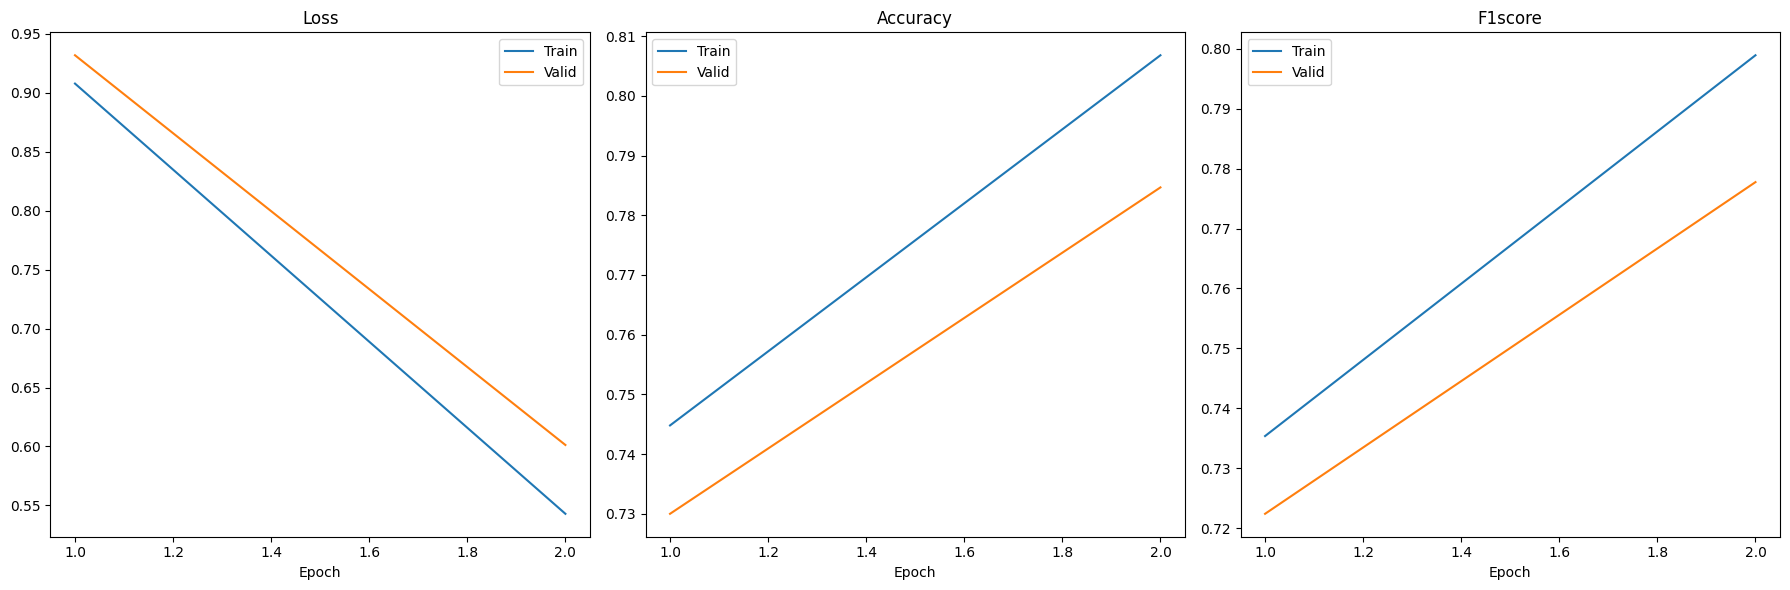


Best metrics:
Loss: 0.6013
Accuracy: 0.7847
F1score: 0.7777
At epoch: 2


In [ ]:
model = Model().to(device)

data  = train_and_evaluate(
    model, train_set, valid_set, BATCH_SIZE=BATCH_SIZE,
    NUM_EPOCHS=NUM_EPOCHS, SUBSET_SIZE=SUBSET_SIZE, LR=LR, device=device)